### Uses CROCO surface variables for Spectral Analysis
##### Computes SST'xHFX' and regression coefficient

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
#functions
def uvw2rho_3d(ufield,vfield,wfield):
    ur_field = 0.5 * (ufield[:,:,:-1] + ufield[:,:,1:])
    ur_field = ur_field[:,1:-1,:]
    vr_field = 0.5 * (vfield[:,:-1,:] + vfield[:,1:,:])
    vr_field = vr_field[:,:,1:-1]

    wr_field = wfield[:,1:-1,1:-1]

    return ur_field,vr_field,wr_field

In [3]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:])

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:])

In [4]:
dxx=111*(np.diff(varf['nav_lat_rho'][:,0]).mean() +np.diff(varf['nav_lon_rho'][0,:]).mean())/2
# dxx=0.00485*111
dyy=dxx

In [5]:
111e3*(np.diff(varf['nav_lat_rho'][:,0]).mean() +np.diff(varf['nav_lon_rho'][0,:]).mean())/2

480.2188603207469

In [6]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [7]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

In [8]:
# plt.figure()
# varf.nav_lat_u[:,0].compute().plot(label='u')
# varf.nav_lat_v[:,0].compute().plot(label='v',linestyle='--',alpha=0.8)
# plt.xlim(1515,1521);plt.ylim(38,38.5)
# # plt.xlim(-0.1,3);plt.ylim(32,33)


# plt.legend()

# plt.figure()

# varf.nav_lon_u[0,:].compute().plot(label='u',linestyle='--')
# varf.nav_lon_v[0,:].compute().plot(label='v',linestyle='--',alpha=0.5)
# # plt.xlim(-0.1,3);plt.ylim(-125,-124)
# plt.xlim(997,1001);plt.ylim(-122,-119)
# plt.legend()

In [9]:
#common grids
ufnew,vfnew,wfnew=uvw2rho_3d(varf.u,varf.v,varf.w)
utnew,vtnew,wtnew=uvw2rho_3d(vart.u,vart.v,vart.w)

xlat,xlon=varf.nav_lat_rho[1:-1,1:-1],varf.nav_lon_rho[1:-1,1:-1]

## Spectral Analysis

#### Test - SST and Heatflux

In [9]:

tf=varf.temp.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
tt=vart.temp.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
ht=-vart.shflx.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

In [10]:
exspec=xrft.isotropic_power_spectrum(tf[0].drop(['nav_lat_rho','nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)

TTf=np.zeros([tf.shape[0],exspec.shape[0]])*np.nan;
TTt=np.zeros([tt.shape[0],exspec.shape[0]])*np.nan;

for ixx in range(tf.shape[0]):
    print(ixx,end=' ',flush=True)


    tpf=xrft.isotropic_power_spectrum(tf[ixx].drop(['nav_lat_rho','nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
    tpt=xrft.isotropic_power_spectrum(tt[ixx].drop(['nav_lat_rho','nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)


    TTf[ixx,:]=(tpf.to_numpy())
    TTt[ixx,:]=(tpt.to_numpy())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


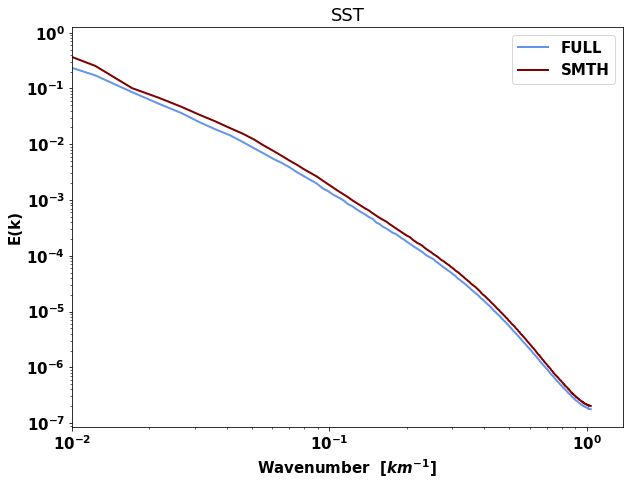

In [13]:
plt.figure(figsize=(9,7))


plt.plot(exspec.freq_r/dxx,np.nanmean(TTf,axis=0),label='FULL',linewidth=2,color='cornflowerblue')

plt.plot(exspec.freq_r/dxx,np.nanmean(TTt,axis=0),label='SMTH',linewidth=2,color='maroon')


plt.legend()

plt.yscale('log')
plt.xscale('log')


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])


plt.title('SST')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Total_avg_SST.png')

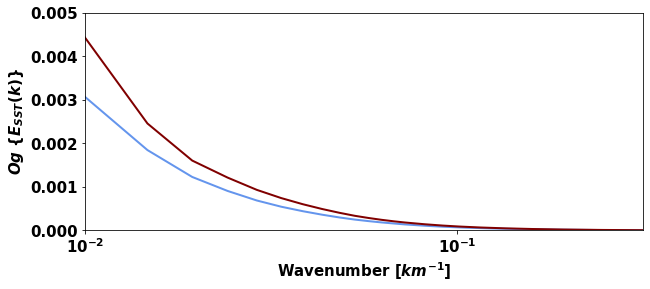

In [53]:
'Ogive graph - Backwards'


Tof=np.nanmean(TTf,axis=0)
Tot=np.nanmean(TTt,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


TOf=integ.cumtrapz(y=Tof[::-1],x=Kk[::-1]);
TOt=integ.cumtrapz(y=Tot[::-1],x=Kk[::-1]);

TOf=-TOf[::-1]
TOt=-TOt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),TOf,label='FULL',linewidth=2,color='cornflowerblue')
ax.plot((np.log10(Kx)),TOt,label='SMTH',linewidth=2,color='maroon')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{SST}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(0,5e-3)

plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Total_Ogive_SST.png')

In [11]:

sf=varf.salt.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
st=vart.salt.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

wf=wfnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
wt=wtnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

In [12]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [13]:
bf=xroms.buoyancy(rhof)[:,1:-1,:]
bt=xroms.buoyancy(rhot)[:,1:-1,:]

In [33]:
exspec=spec.CO_TWODimensional_spec(bf[0],wf[0],dxx,dyy)
# plt.plot(exspec.ki,exspec.ispec)


In [71]:
exspec=spec.CO_TWODimensional_spec(bf[0],wf[0],dxx,dyy)
# isospec=spec.calc_ispec(exspec.k1,exspec.k2,exspec.spec)


VBPf=np.zeros([bf.shape[0],exspec.ki.shape[0]])*np.nan;

VBPt=np.zeros([bt.shape[0],exspec.ki.shape[0]])*np.nan;

for ixx in range(bf.shape[0]):
    VBf=spec.CO_TWODimensional_spec(bf[ixx],wf[ixx],dxx,dyy)
    VBt=spec.CO_TWODimensional_spec(bt[ixx],wt[ixx],dxx,dyy)
    
    VBPf[ixx,:]=(VBf.ispec)
    VBPt[ixx,:]=(VBt.ispec)




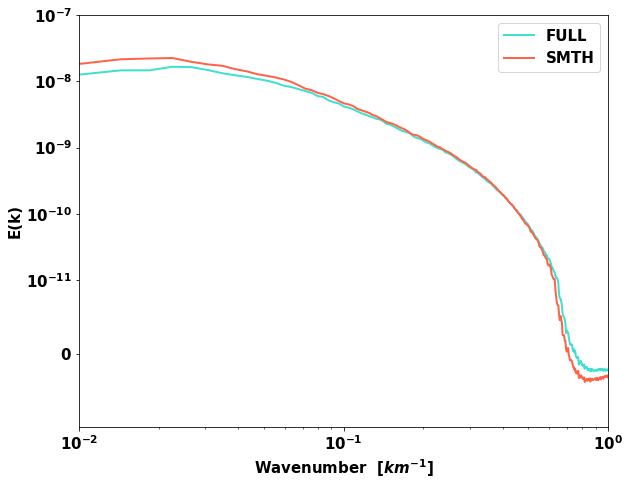

In [77]:

plt.figure(figsize=(9,7))


plt.plot(exspec.ki,np.nanmean(VBPf,axis=0),label='FULL',linewidth=2,color='turquoise')

plt.plot(exspec.ki,np.nanmean(VBPt,axis=0),label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')





plt.legend()

plt.yscale('symlog',linthreshy=1e-11)
plt.xscale('log')



# plt.title('EKE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,1)
plt.ylim(-1e-11,1e-7)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/Total_VBP.png')

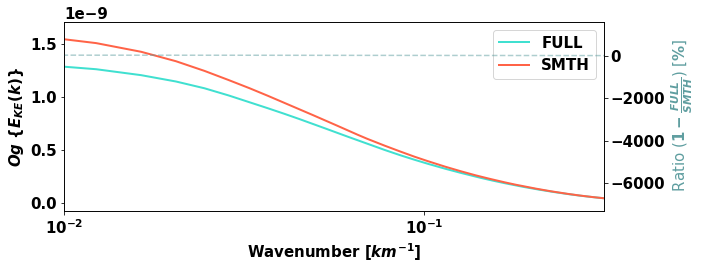

In [79]:
'Ogive graph - Backwards'


Kf=np.nanmean(VBPf,axis=0)
Kt=np.nanmean(VBPt,axis=0)

Kk=np.array(exspec.ki)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='turquoise')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='tomato')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
# ax.set_ylim(-1e-5,5e-4)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/Ogive_Total_VBP.png')

In [14]:
# cxspec=xrft.isotropic_cross_spectrum(bf[0].drop(['nav_lat_rho', 'nav_lon_rho']),wf[0].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear',window=True)



# VBPf=np.zeros([bf.shape[0],cxspec.shape[0]])*np.nan;
# VBPt=np.zeros([bt.shape[0],cxspec.shape[0]])*np.nan;


# for ixx in range(tf.shape[0]):
#     print(ixx,end=' ',flush=True)
#     'Full'
#     VBf_hat=xrft.isotropic_cross_spectrum(bf[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),wf[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
#     VBf_hat=VBf_hat.real
    
#     'Smth'
#     VBt_hat=xrft.isotropic_cross_spectrum(bt[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),wt[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
#     VBt_hat=VBt_hat.real

#     VBf[ixx,:]=VBf_hat.to_numpy()
#     VBt[ixx,:]=VBt_hat.to_numpy()

# Calculating EKE

In [125]:
uf=ufnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 
vf=vfnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 


ut=utnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 
vt=vtnew.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 

exspec=xrft.isotropic_power_spectrum(uf[0],nfactor=2,truncate='True',detrend='linear', window=True)

Ekef=np.zeros([uf.shape[0],exspec.shape[0]])*np.nan;
Eket=np.zeros([ut.shape[0],exspec.shape[0]])*np.nan;

for ixx in range(uf.shape[0]):
    print(ixx,end=' ',flush=True)

    upf=xrft.isotropic_power_spectrum(uf[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    vpf=xrft.isotropic_power_spectrum(vf[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    
    upt=xrft.isotropic_power_spectrum(ut[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    vpt=xrft.isotropic_power_spectrum(vt[ixx],nfactor=2,truncate='True',detrend='linear', window=True)


    Ekef[ixx,:]=0.5*(upf.to_numpy()+vpf.to_numpy())
    Eket[ixx,:]=0.5*(upt.to_numpy()+vpt.to_numpy())

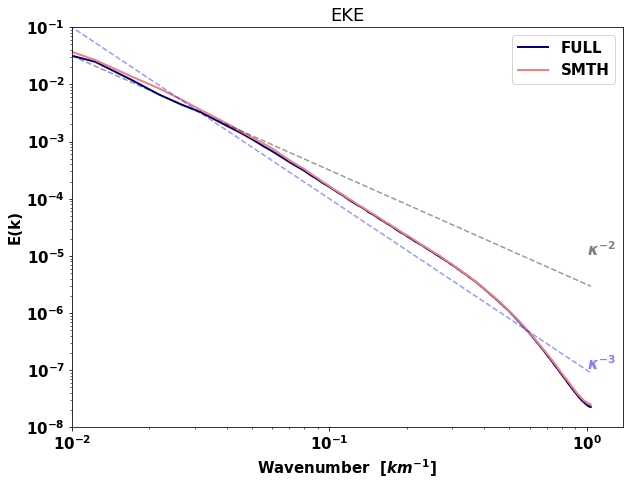

In [171]:

plt.figure(figsize=(9,7))


plt.plot(exspec.freq_r/dxx,np.nanmean(Ekef,axis=0),label='FULL',linewidth=2,color='navy')

plt.plot(exspec.freq_r/dxx,np.nanmean(Eket,axis=0),label='SMTH',linewidth=2,color='lightcoral')

# plt.plot([1/50,1/50],[1000,0],'k--')


k2 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**5.5)


k3 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**7)

k53 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E53 = (1/k53)**(5/3)/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-7,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)

# plt.plot(k53,E53,'g--',alpha=0.4)
# plt.text(1,1e-3,r'$\kappa^{-5/3}$',weight='normal',color='g',alpha=0.5)




plt.legend()

plt.yscale('log')
plt.xscale('log')



plt.title('EKE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(1e-8,1e-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Total_avg_KE.png')

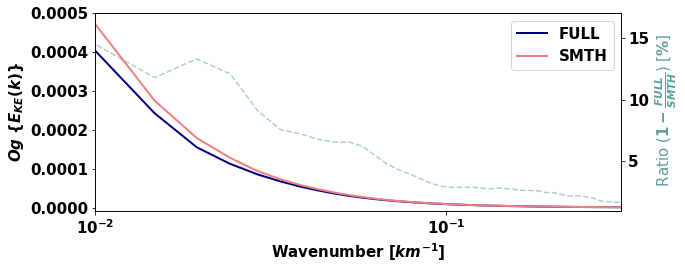

In [175]:
'Ogive graph - Backwards'


Kf=np.nanmean(Ekef,axis=0)
Kt=np.nanmean(Eket,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='navy')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='lightcoral')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(-1e-5,5e-4)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Ogive_avg_KE.png')

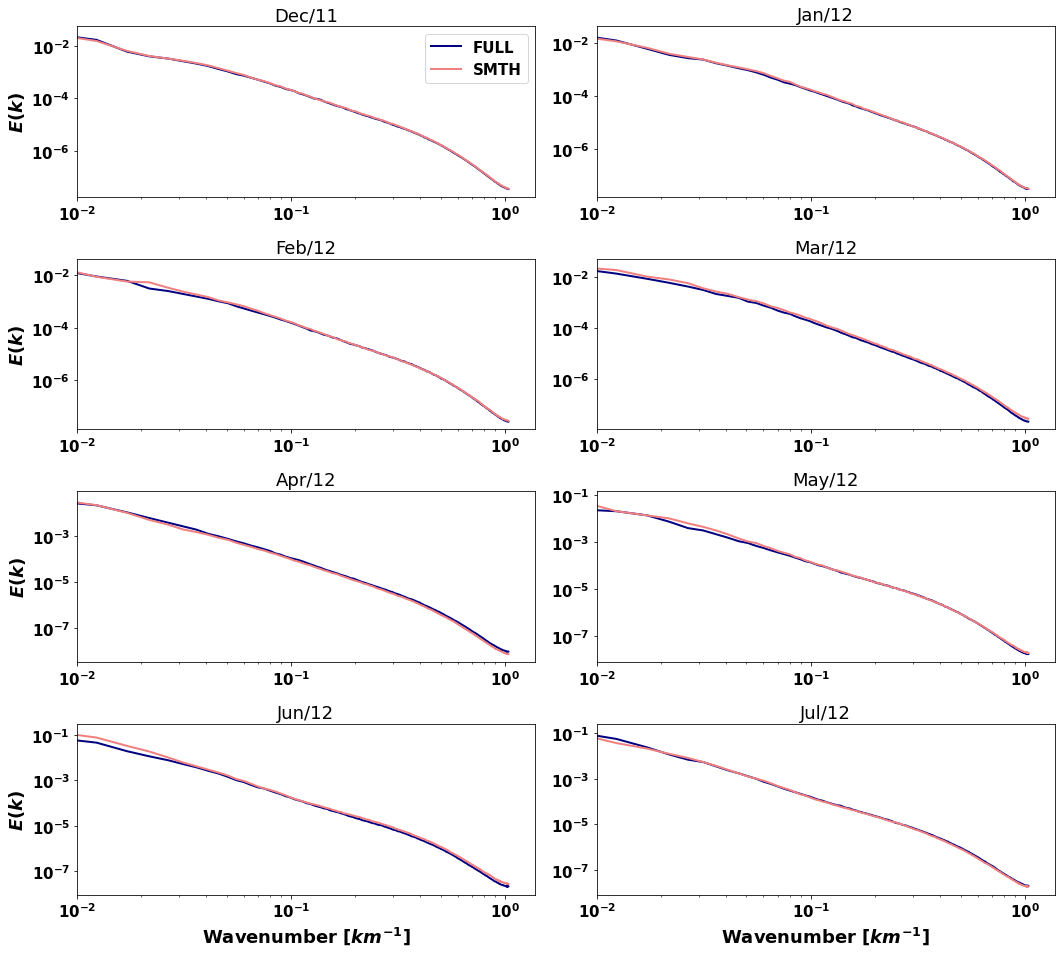

In [298]:
fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot((exspec.freq_r/dxx),(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='navy')
    axs[ipp].plot((exspec.freq_r/dxx),(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='lightcoral')
    # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
    # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
    # axs[ipp].grid()
    axs[ipp].set_xscale('log')
    axs[ipp].set_yscale('log')



    axs[ipp].set_title(mes_str[ipp])
    # axs[ipp].set_xticks(np.array([-2,-1]))
    # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
    # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

    axs[0].legend()


    axs[ipp].set_xlim(1e-2,0)
    # axs[ipp].set_ylim(-6,-1)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/monthly_KE.png')

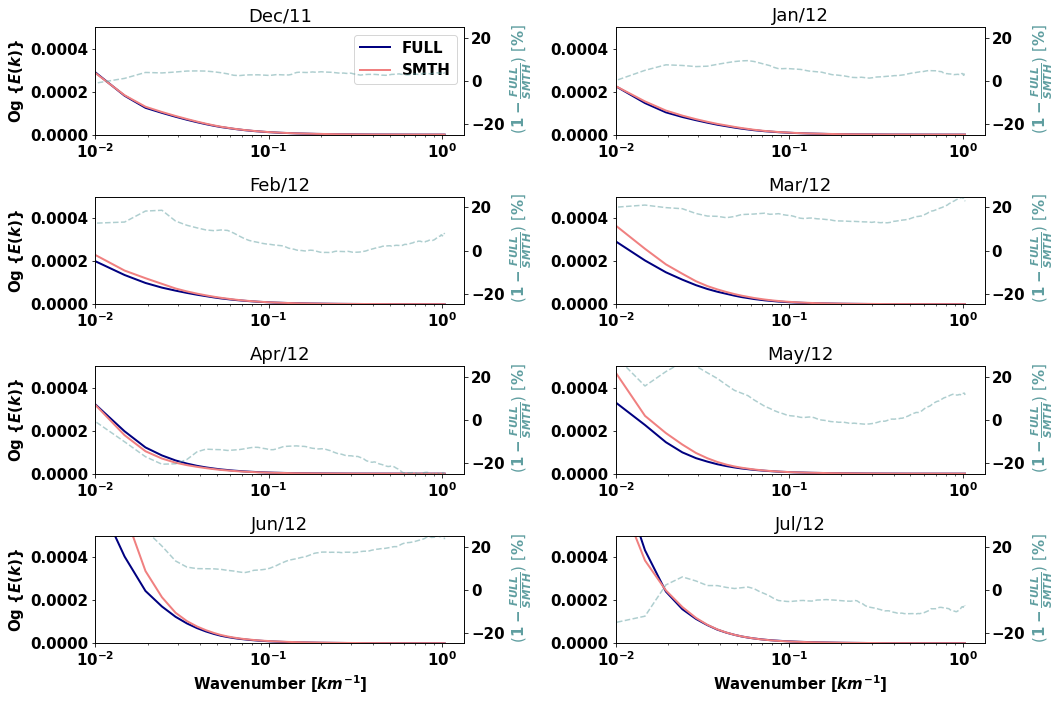

In [300]:
fig, axs = plt.subplots(4,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    emf=np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)
    emt=np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(exspec.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    KEf=integ.cumtrapz(y=emf[::-1],x=Kk[::-1]);
    KEt=integ.cumtrapz(y=emt[::-1],x=Kk[::-1]);
    KEf=-KEf[::-1]
    KEt=-KEt[::-1]

    

    
    axs[ipp].plot((Kx),KEf,label='FULL',linewidth=2,color='navy')
    axs[ipp].plot((Kx),KEt,label='SMTH',linewidth=2,color='lightcoral')

    axs[ipp].set_title(mes_str[ipp])
    axs[ipp].set_xscale('log')

    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'Og {$E(k)$}',color="k",fontsize=15,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')

    axs[0].legend()
    axs[ipp].set_xlim(1e-2,0)
    axs[ipp].set_ylim(-1e-6,5e-4)


#     axs[ipp].set_xticks(np.array([-2,-1]))
#     axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    

    ax2=axs[ipp].twinx()
    ax2.plot((Kx),(1-(KEf)/(KEt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    # if ipp in [2,5,8]:
    ax2.set_xscale('log')
    ax2.set_ylabel(r' ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    ax2.set_ylim(-25,25)
    plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Ogive_monthly_KE.png')

    

## Windwork

In [99]:
#loading stress
ustressf,vstressf,_=uvw2rho_3d(varf.sustr,varf.svstr,varf.svstr)
ustresst,vstresst,_=uvw2rho_3d(vart.sustr,vart.svstr,vart.svstr)

usf=ustressf.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 
vsf=vstressf.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 

ust=ustresst.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 
vst=vstresst.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700] 




In [271]:
cxspec=xrft.isotropic_cross_spectrum(uf[0],usf[0],nfactor=2,truncate='True',detrend='linear', window=True)
WWf=np.zeros([usf.shape[0],cxspec.shape[0]])*np.nan;
WWt=np.zeros([ust.shape[0],cxspec.shape[0]])*np.nan;


for ixx in range(uf.shape[0]):
    print(ixx,end=' ',flush=True)
    'Full'
    Xf_hat=xrft.isotropic_cross_spectrum(usf[ixx],uf[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    Yf_hat=xrft.isotropic_cross_spectrum(vsf[ixx],vf[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    Xf_hat=Xf_hat.real
    Yf_hat=Yf_hat.real
    
    'Smth'
    Xt_hat=xrft.isotropic_cross_spectrum(ust[ixx],ut[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    Yt_hat=xrft.isotropic_cross_spectrum(vst[ixx],vt[ixx],nfactor=2,truncate='True',detrend='linear', window=True)
    Xt_hat=Xt_hat.real
    Yt_hat=Yt_hat.real

    WWf[ixx,:]=(Xf_hat.to_numpy() + Yf_hat.to_numpy())*(1/1024)
    WWt[ixx,:]=(Xt_hat.to_numpy() + Yt_hat.to_numpy())*(1/1024)



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 

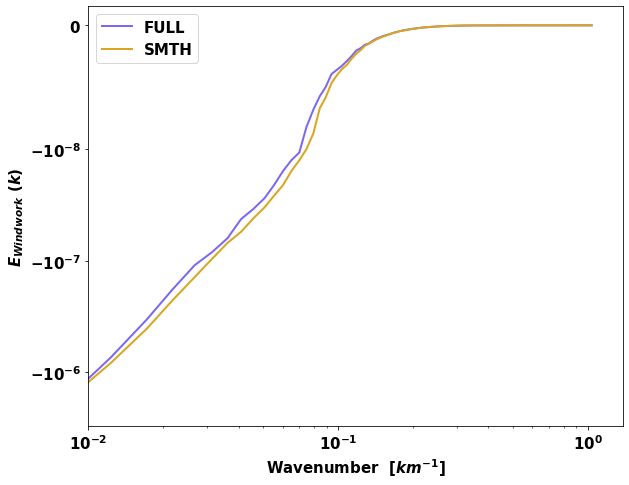

In [295]:

plt.figure(figsize=(9,7))


plt.plot((exspec.freq_r/dxx),(np.nanmean(WWf,axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
plt.plot((exspec.freq_r/dxx),(np.nanmean(WWt,axis=0)),label='SMTH',linewidth=2,color='goldenrod')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()

# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{Windwork}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-8)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Total_avg_Windwork_KE.png')



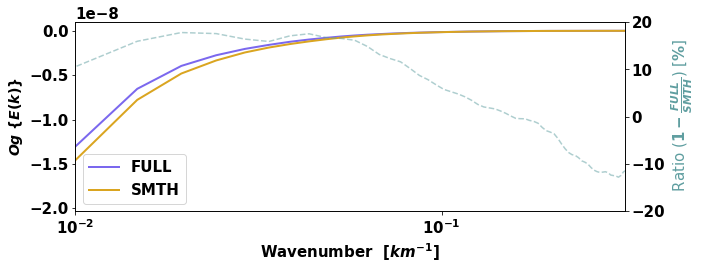

In [302]:
'Ogive'

wwf=np.nanmean(WWf,axis=0)
wwt=np.nanmean(WWt,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


WWpf=integ.cumtrapz(y=wwf[::-1],x=Kk[::-1]);
WWpt=integ.cumtrapz(y=wwt[::-1],x=Kk[::-1]);
WWpf=-WWpf[::-1]
WWpt=-WWpt[::-1]



fig,ax = plt.subplots(figsize=(10,4))
ax.plot(np.log10(Kx),WWpf,label='FULL',linewidth=2,color='mediumslateblue')
ax.plot(np.log10(Kx),WWpt,label='SMTH',linewidth=2,color='goldenrod')
ax.set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E(k)$}',color="k",fontsize=14,fontweight='bold')

ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
# ax.set_ylim(0,6e-11)
ax.set_xlim(-2,-0.5)
ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-((WWpf)/(WWpt)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
ax2.set_ylim(-20,20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/Ogive_avg_Windwork.png')




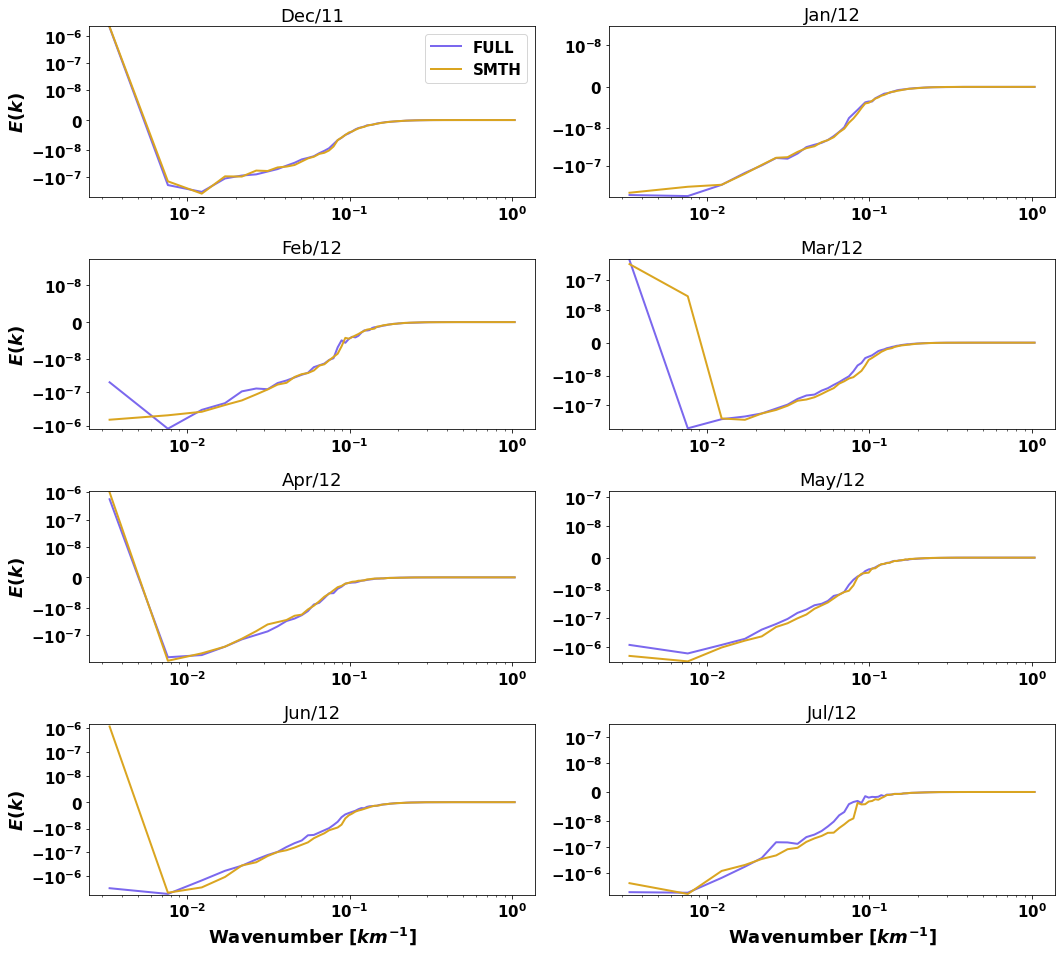

In [304]:
fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot((exspec.freq_r/dxx),(np.nanmean(WWf[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
    axs[ipp].plot((exspec.freq_r/dxx),(np.nanmean(WWt[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='goldenrod')
    # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
    # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
    # axs[ipp].grid()
    axs[ipp].set_xscale('log')
    axs[ipp].set_yscale('symlog',linthreshy=1e-8)



    axs[ipp].set_title(mes_str[ipp])
    # axs[ipp].set_xticks(np.array([-2,-1]))
    # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
    # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

    axs[0].legend()


    # axs[ipp].set_xlim(1e-2,0)
    # axs[ipp].set_ylim(-6,-1)


plt.tight_layout()

## SST x HFX

In [90]:
#testing accuracy of groupby
# plt.figure(figsize=(30,12))
# plt.plot(varf.time_counter.groupby("time_counter.dayofyear").mean(),varf.temp.groupby("time_counter.dayofyear").mean()[:,760,500])
# plt.plot(varf.time_counter,varf.temp[:,760,500],'o')

# plt.figure(figsize=(30,12))
# plt.plot(vart.time_counter.groupby("time_counter.dayofyear").mean(),vart.temp.groupby("time_counter.dayofyear").mean()[:,760,500])
# plt.plot(vart.time_counter,vart.temp[:,760,500],'o')


In [91]:


tf=varf.temp.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
tt=vart.temp.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()
ht=-vart.shflx.groupby("time_counter.dayofyear").mean()[:,300:-300,90:700].compute()

In [14]:
cxspec=xrft.isotropic_cross_spectrum(tf[0].drop(['nav_lat_rho', 'nav_lon_rho']),hf[0].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
Gf=np.zeros([tf.shape[0],cxspec.shape[0]])*np.nan;
Gt=np.zeros([tt.shape[0],cxspec.shape[0]])*np.nan;


for ixx in range(tf.shape[0]):
    print(ixx,end=' ',flush=True)
    'Full'
    Gf_hat=xrft.isotropic_cross_spectrum(tf[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),hf[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
    Gf_hat=Gf_hat.real
    
    'Smth'
    Gt_hat=xrft.isotropic_cross_spectrum(tt[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),ht[ixx].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
    Gt_hat=Gt_hat.real

    Gf[ixx,:]=Gf_hat.to_numpy()
    Gt[ixx,:]=Gt_hat.to_numpy()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


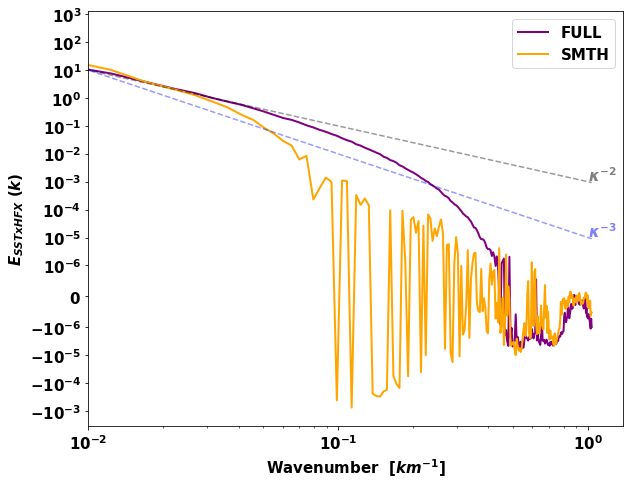

In [15]:

plt.figure(figsize=(9,7))


plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gf,axis=0)),label='FULL',linewidth=2,color='purple')
plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gt,axis=0)),label='SMTH',linewidth=2,color='orange')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()



k2 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**3)


k3 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**5)

k53 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E53 = (1/k53)**(5/3)/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-3,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{SSTxHFX}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-6)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/2Total_avg_SSTxshflx.png')




## Computing (SSTxHFX)/(SST)^2

In [14]:
(np.nanmean(Gf/TTf,axis=0))

array([ 3.70706451e+01,  3.95517932e+01,  4.08941223e+01,  4.01350487e+01,
        3.96364474e+01,  3.86125983e+01,  3.93571965e+01,  3.84507279e+01,
        3.81129707e+01,  3.73338973e+01,  3.69010438e+01,  3.56980124e+01,
        3.55561862e+01,  3.49671499e+01,  3.48093221e+01,  3.31753754e+01,
        3.29974146e+01,  3.26371703e+01,  3.23986475e+01,  3.24907590e+01,
        3.11951653e+01,  2.99283704e+01,  2.89278502e+01,  2.93195673e+01,
        2.78621081e+01,  2.77646184e+01,  2.68654578e+01,  2.57029280e+01,
        2.52256120e+01,  2.45975110e+01,  2.34820599e+01,  2.24007077e+01,
        2.17670023e+01,  2.07340166e+01,  2.02969636e+01,  1.93749554e+01,
        1.81803951e+01,  1.74543919e+01,  1.64884097e+01,  1.54295960e+01,
        1.47163107e+01,  1.44856736e+01,  1.32570476e+01,  1.25072056e+01,
        1.23192092e+01,  1.09360277e+01,  1.07527430e+01,  1.00508752e+01,
        9.67475312e+00,  9.16088084e+00,  8.84602704e+00,  8.29862011e+00,
        7.60374246e+00,  

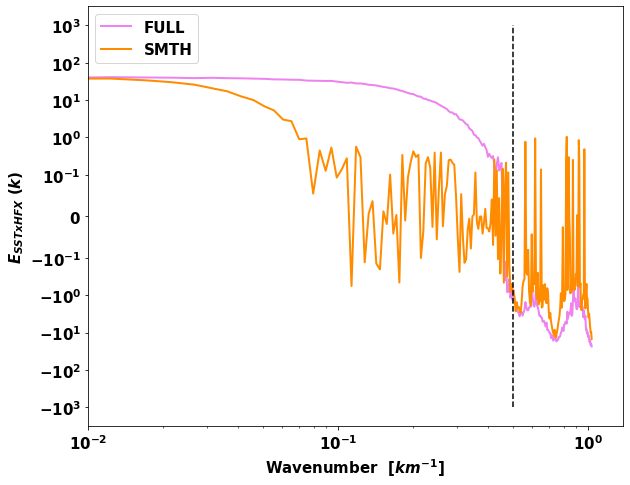

In [13]:
plt.figure(figsize=(9,7))


plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gf/TTf,axis=0)),label='FULL',linewidth=2,color='violet')
plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gt/TTt,axis=0)),label='SMTH',linewidth=2,color='darkorange')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.plot([1/2,1/2],[-1e3,1e3],'k--')
plt.legend()


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{SSTxHFX}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-1)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/coefficient_GdivT.png')



## Filtering SST and HFLX

In [9]:
import scipy.signal as sig

def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()



def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of typical
    size n. The optional keyword argument ny allows for a different
    size in the y direction.
    """
    g = gauss_kern(n, sizey=ny)
    improc = sig.convolve(im,g, mode='valid')
    return(improc)

In [11]:
# tdata=(tf - tf.mean(axis=0)).compute()
# xtdata=tdata.to_numpy()


tdata=tf.compute()
xtdata=tdata.to_numpy()

In [60]:

fT0=np.empty(tdata.shape)*np.nan

gnum=4
for iss in range(tdata.shape[0]):
    
        ff0=gauss(tdata[iss,:,:],gnum)
        fT0[iss,:,:]=ff0

fT=fT0

In [61]:
# butt0=sig.blackman(107)
# butt0=butt0/butt0.sum()

# butt1=sig.blackman(214) #
# butt1=butt1/butt1.sum()


# fT0=np.empty(tdata.shape)*np.nan
# fT1=np.empty(tdata.shape)*np.nan


# for iss in range(tdata.shape[2]):
#     for itt in range(tdata.shape[1]):

#         ff0=np.convolve(xtdata[:,itt,iss],butt0,mode='same') #acima de lowcut
#         ff1=np.convolve(xtdata[:,itt,iss],butt1,mode='same') #acima de lowcut

#         fT0[:,itt,iss]=ff0
#         fT1[:,itt,iss]=ff1

# fT=fT0-fT1

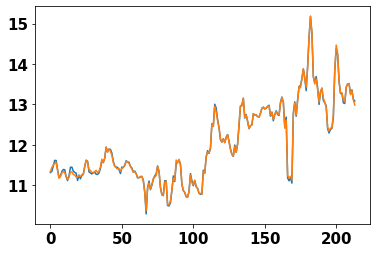

In [62]:
plt.plot(tdata[:,500,500])
plt.plot(fT[:,500,500])

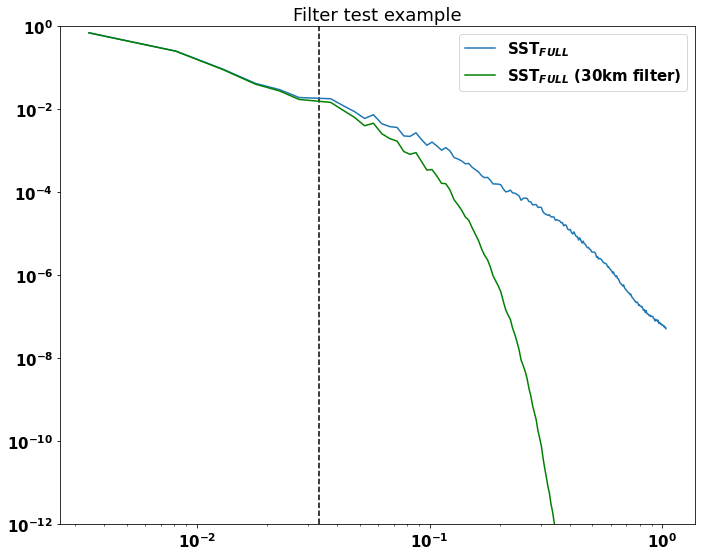

In [129]:

xlim=10
aa=xrft.isotropic_power_spectrum(tdata[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
bb=xrft.isotropic_power_spectrum(xr.DataArray(fT)[0,xlim:-xlim,xlim:-xlim],nfactor=2,truncate='True',detrend='linear', window=True)




plt.figure(figsize=(10,8))
plt.plot([1/30,1/30],[1e-12,1],'k--')
# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')

plt.plot(aa.freq_r/dxx,aa,label=r'SST$_{FULL}$')
plt.plot(bb.freq_r/dxx,bb,color='green',label=r'SST$_{FULL}$ (30km filter)')
plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-12,1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/test_filter.png')

In [26]:
# gtf=tf[0].rolling(x_rho=15, center=True).mean().rolling(y_rho=10, center=True).mean()
# gtt=tt[0].rolling(x_rho=15, center=True).mean().rolling(y_rho=10, center=True).mean()


# xlim=15
# aa=xrft.isotropic_power_spectrum(tf[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# bb=xrft.isotropic_power_spectrum(gtf[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)


# cc=xrft.isotropic_power_spectrum(tt[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# dd=xrft.isotropic_power_spectrum(gtt[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)



# plt.figure(figsize=(10,8))
# plt.plot([1/30,1/30],[1e-12,1],'k--')
# # plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

# plt.title('Filter test example')

# plt.plot(aa.freq_r/dxx,aa,label=r'SST$_{FULL}$')
# plt.plot(bb.freq_r/dxx,bb,color='green',label=r'SST$_{FULL}$ (30km filter)')
# plt.legend()

# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-12,1)
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/test_filter.png')





# plt.figure(figsize=(10,8))
# plt.plot([1/30,1/30],[1e-11,1e-2],'k--')
# # plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

# plt.title('Filter test example')

# plt.plot(cc.freq_r/dxx,cc,label=r'SST$_{FULL}$')
# plt.plot(dd.freq_r/dxx,dd,color='green',label=r'SST$_{FULL}$ (30km filter)')
# plt.legend()

# plt.yscale('log')
# plt.xscale('log')

In [47]:
dxx*30

14.406565809622407

In [69]:
# Filtering for 30km

# gtf=np.zeros(tf.shape)*np.nan
# gtt=np.zeros(tf.shape)*np.nan

# ghf=np.zeros(tf.shape)*np.nan
# ght=np.zeros(tf.shape)*np.nan

# for ig in range(tf.shape[0]):
#     gtf[ig,:,:]=tf[ig].rolling(x_rho=20, center=True).mean().rolling(y_rho=20, center=True).mean().compute()
#     gtt[ig,:,:]=tt[ig].rolling(x_rho=20, center=True).mean().rolling(y_rho=20, center=True).mean().compute()

#     ghf[ig,:,:]=hf[ig].rolling(x_rho=20, center=True).mean().rolling(y_rho=20, center=True).mean().compute()
#     ght[ig,:,:]=ht[ig].rolling(x_rho=20, center=True).mean().rolling(y_rho=20, center=True).mean().compute()

In [64]:
# Filtering for 30km

gtf=np.zeros(tf.shape)*np.nan
gtt=np.zeros(tf.shape)*np.nan

ghf=np.zeros(tf.shape)*np.nan
ght=np.zeros(tf.shape)*np.nan

for ig in range(tf.shape[0]):
    gtf[ig,:,:]=gauss(tf[ig,:,:],gnum)
    gtt[ig,:,:]=gauss(tt[ig,:,:],gnum)

    ghf[ig,:,:]=gauss(hf[ig,:,:],gnum)
    ght[ig,:,:]=gauss(ht[ig,:,:],gnum)

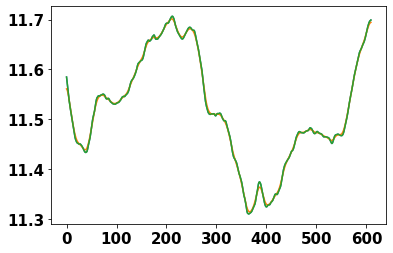

In [65]:
plt.figure()
plt.plot(np.nanmean(tf[0],axis=0))
plt.plot(np.nanmean(gtf[0],axis=0))
plt.plot(tf[0].mean(axis=0))

In [66]:
phf=(hf.to_numpy()-ghf)
ptf=(tf.to_numpy() - gtf)
pht=(ht.to_numpy()-ght)
ptt=(tt.to_numpy() - gtt)

In [67]:
phf.shape

(214, 920, 610)

In [68]:
Rsq=np.zeros([phf.shape[0]])*np.nan;
for icc in range(Rsq.shape[0]):
    Rsq[icc]=np.corrcoef(phf[icc][~np.isnan(phf[icc])],ptf[icc][~np.isnan(ptf[icc])])[0][1]

In [71]:
Rsq

array([0.47184198, 0.50553503, 0.21353386, 0.37464735, 0.56304683,
       0.58281005, 0.74479326, 0.59152022, 0.34603927, 0.39579973,
       0.41605292, 0.2023951 , 0.15313579, 0.19864962, 0.41052347,
       0.3688119 , 0.30826952, 0.39542992, 0.40502334, 0.52203555,
       0.55423586, 0.55871302, 0.40993591, 0.64068434, 0.277428  ,
       0.27088996, 0.64553607, 0.74654821, 0.34455121, 0.25461015,
       0.25311369, 0.18651918, 0.30911366, 0.28616572, 0.13450438,
       0.21074209, 0.56563391, 0.49488237, 0.33920732, 0.12625892,
       0.22564206, 0.2906096 , 0.3254605 , 0.36148701, 0.4082156 ,
       0.50311922, 0.46387843, 0.31230547, 0.26835193, 0.28662258,
       0.41629916, 0.27519306, 0.31132793, 0.67428416, 0.76850553,
       0.50847002, 0.57772619, 0.42869412, 0.24557926, 0.20294263,
       0.15691337, 0.38813523, 0.31879287, 0.17898289, 0.25762088,
       0.35490231, 0.48892367, 0.16541711, 0.08128746, 0.25370755,
       0.26836205, 0.17224998, 0.28037581, 0.1750062 , 0.15711

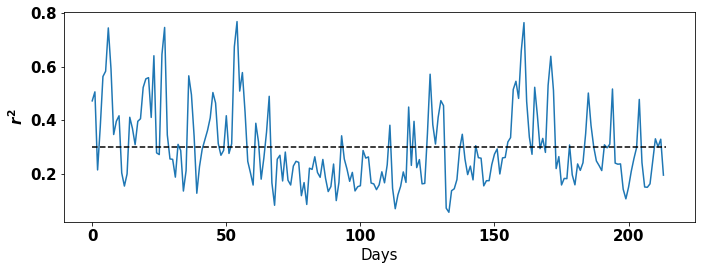

In [127]:
plt.figure(figsize=(10,4))

plt.plot(Rsq)
plt.plot([0,214],[np.nanmean(Rsq),np.nanmean(Rsq)],'k--')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/coeff_daily_fluctuations.png')



In [73]:
CCtotal=np.corrcoef(phf[~np.isnan(phf)],ptf[~np.isnan(ptf)])[0][1]

In [74]:
np.nanmean(Rsq)

0.2991568154151688

In [120]:
af,bf=np.polyfit(phf.mean(0).ravel(),ptf.mean(0).ravel(),deg=1)
line=np.linspace(-1.5,1.5,100)*af + bf

In [138]:
linestring='y = {0:.4f}x'.format(af)#+ '{0:.4f}'.format(bf)
linestring

'y = 0.0037x'

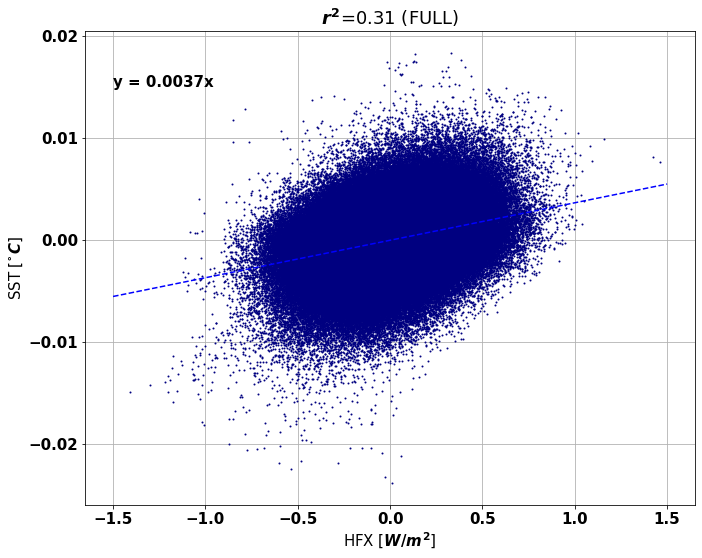

In [140]:
plt.figure(figsize=(10,8))
plt.plot(phf.mean(0).ravel(),ptf.mean(0).ravel(),'o',color='navy',markersize=1)
plt.plot(np.linspace(-1.5,1.5,100),line,'b--')
plt.title(r'$r^2$='+'{0:.2f} (FULL)'.format(np.corrcoef(phf.mean(0).ravel(),ptf.mean(0).ravel())[0][1]))

plt.text(-1.5,0.015, linestring)
# plt.title(r'$r^2$='+'{0:.2f} (FULL)'.format(np.corrcoef(phf.mean(0)[~np.isnan(phf.mean(0))],ptf.mean(0)[~np.isnan(ptf.mean(0))])[0][1]))
plt.xlabel(r'HFX [$W/m^{2}$]')
plt.ylabel(r'SST [$^{\circ}C$]')
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/coeff_full.png')



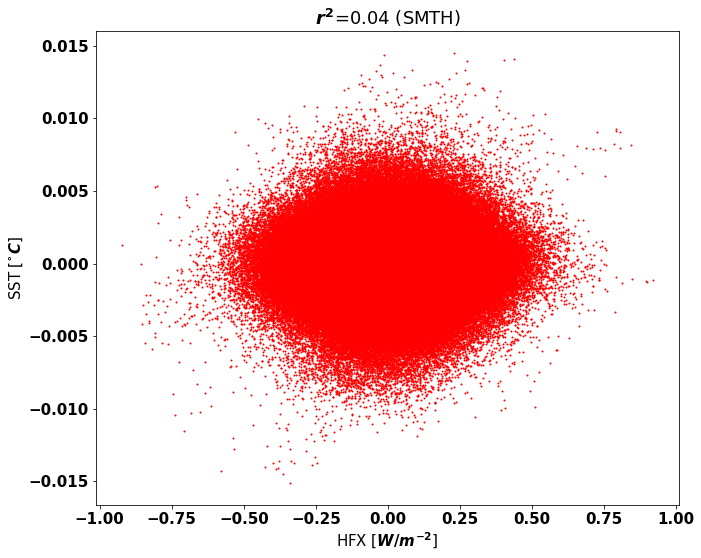

In [37]:
plt.figure(figsize=(10,8))
plt.plot(pht.mean(0).ravel(),ptt.mean(0).ravel(),'o',color='red',markersize=1)
plt.title(r'$r^2$='+'{0:.2f} (SMTH)'.format(np.corrcoef(pht.mean(0)[~np.isnan(pht.mean(0))],ptt.mean(0)[~np.isnan(ptt.mean(0))])[0][1]))
plt.xlabel(r'HFX [$W/m^{-2}$]')
plt.ylabel(r'SST [$^{\circ}C$]')


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/coeff_smth.png')




## Test on heatflux from WRF and CROCO

In [7]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
wlistm=glob(path+'*DAY.nc');wlistm.sort()
# vf=xr.open_dataset(wlistm[-7:][0])
vf=xr.open_mfdataset(wlistm[-7:])


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
wlistt=glob(path+'*DAY.nc');wlistt.sort()
# vt=xr.open_dataset(wlistt[2:][0])
vt=xr.open_mfdataset(wlistt[2:])

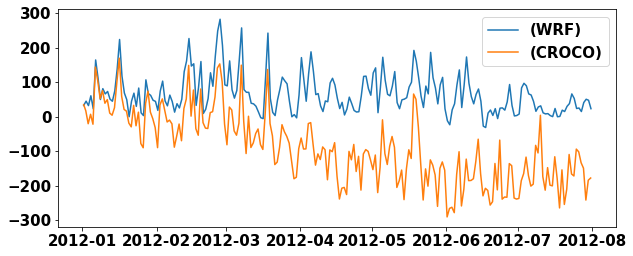

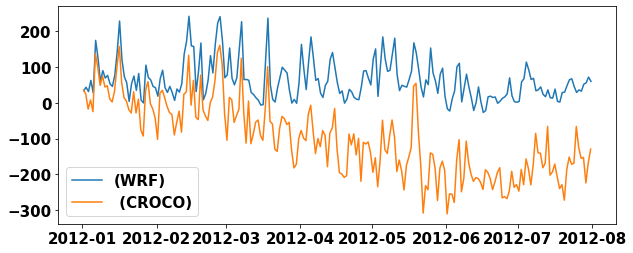

In [43]:

AAA=vf.LH[:,194,150] + vf.HFX[:,194,150] #- vf.GLW[:,194,150] +vf.GSW[:,194,150]
plt.figure(figsize=(10,4))
plt.plot(vf.time_counter,AAA,label='(WRF)')
plt.plot(varf.time_counter.groupby("time_counter.dayofyear").mean()[:-1],
        -varf.shflx.groupby("time_counter.dayofyear").mean()[:,760,500][:-1],label='(CROCO)')
plt.legend()

BBB=vt.LH[:,194,150]+ vt.HFX[:,194,150] #- vt.GLW[:,194,150] + vt.GSW[:,194,150]
plt.figure(figsize=(10,4))
plt.plot(vt.time_counter,BBB,label= '(WRF)')
plt.plot(vart.time_counter.groupby("time_counter.dayofyear").mean()[:-1],
        -vart.shflx.groupby("time_counter.dayofyear").mean()[:,760,500][:-1],label=' (CROCO)')  
plt.legend()




## Cummulative Fluctuations

In [150]:
varf.sustr

<xarray.DataArray 'sustr' (time_counter: 852, y_u: 1520, x_u: 999)>
dask.array<concatenate, shape=(852, 1520, 999), dtype=float32, chunksize=(124, 1520, 999), chunktype=numpy.ndarray>
Coordinates:
    nav_lat_u     (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    nav_lon_u     (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    time_instant  (time_counter) datetime64[ns] dask.array<chunksize=(124,), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2012-01-01T06:00:00 ... 2012-...
Dimensions without coordinates: y_u, x_u
Attributes:
    long_name:           surface u-momentum stress
    units:               N/m2
    online_operation:    instant
    interval_operation:  6 h
    interval_write:      6 h
    cell_methods:        time: point

In [159]:
0.5*(ufnew[0,760,500].compute()**2 + vfnew[0,760,500].compute()**2 )

<xarray.DataArray ()>
array(0.0078705)
Coordinates:
    time_instant  datetime64[ns] 2012-01-01T06:00:00
    time_counter  datetime64[ns] 2012-01-01T06:00:00

In [153]:
'Kinetic Energy'
Kef=(0.5*(ufnew[:,760,500]**2 + vfnew[:,760,500]**2)).compute()
Ket=(0.5*(utnew[:,760,500]**2 + vtnew[:,760,500]**2)).compute()


'Wind work'
Fkf=((1/1024)*(ustressf[:,760,500]*ufnew[:,760,500] +vstressf[:,760,500]*vfnew[:,760,500])).compute()
Fkt=((1/1024)*(ustresst[:,760,500]*utnew[:,760,500] +vstresst[:,760,500]*vtnew[:,760,500])).compute()


'Wind Kinetic Energy'
WKef=(0.5*(vf.U10[:,195,150]**2 + vf.V10[:,195,150]**2)).compute()
WKet=(0.5*(vt.U10[:,195,150]**2 + vt.V10[:,195,150]**2)).compute()

In [171]:
vf.time_counter[100].data

array('2012-04-10T12:00:00.000000000', dtype='datetime64[ns]')

In [170]:
ufnew.time_counter[400]

<xarray.DataArray 'time_counter' ()>
array('2012-04-10T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time_instant  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter  datetime64[ns] 2012-04-10T06:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1979-01-01 00:00:00
    bounds:         time_counter_bounds

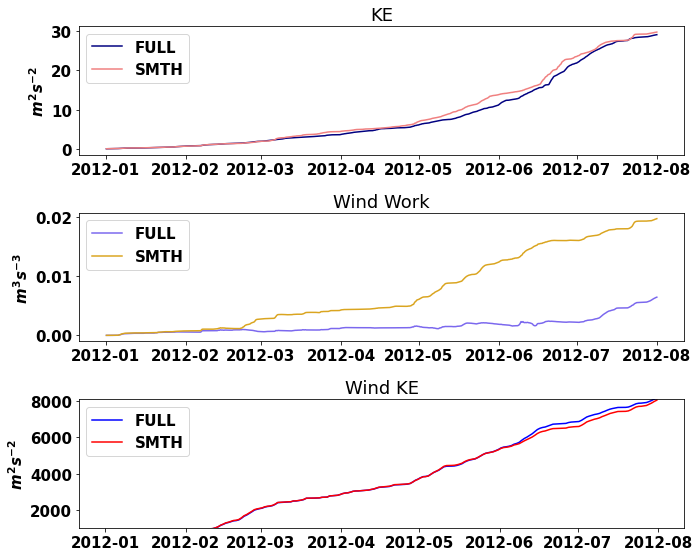

In [183]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(ufnew.time_counter,np.cumsum(Kef),label='FULL',color='navy')
plt.plot(utnew.time_counter,np.cumsum(Ket),label='SMTH',color='lightcoral')
plt.title('KE')
plt.ylabel(r'$m^2 s^{-2}$')
plt.legend()
# plt.xlim(ufnew.time_counter[400].data,ufnew.time_counter[-1].data)
# plt.ylim(5,30)

plt.subplot(3,1,2)

plt.plot(ufnew.time_counter,np.cumsum(Fkf),label='FULL',color='mediumslateblue')
plt.plot(utnew.time_counter,np.cumsum(Fkt),label='SMTH',color='goldenrod')
plt.legend()
plt.title('Wind Work')
plt.ylabel(r'$m^3 s^{-3}$')
# plt.xlim(ufnew.time_counter[400].data,ufnew.time_counter[-1].data)





plt.subplot(3,1,3)

plt.plot(vf.time_counter,np.cumsum(WKef),label='FULL',color='blue')
plt.plot(vt.time_counter,np.cumsum(WKet),label='SMTH',color='red')
plt.title('Wind KE')
plt.ylabel(r'$m^2 s^{-2}$')
plt.legend()
plt.tight_layout()
# plt.xlim(vf.time_counter[100].data,vf.time_counter[-1].data)
plt.ylim(1000,8100)

plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/central_p_cumulative_energetics.png')




In [187]:
'Kinetic Energy'
Kef1=(0.5*(ufnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)**2 + vfnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)**2)).compute()
Ket1=(0.5*(utnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)**2 + vtnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)**2)).compute()


'Wind work'
Fkf1=((1/1024)*(ustressf[:,100:-100,90:700].mean(axis=1).mean(axis=1)*ufnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)
              +vstressf[:,100:-100,90:700].mean(axis=1).mean(axis=1)*vfnew[:,100:-100,90:700].mean(axis=1).mean(axis=1))).compute()
Fkt1=((1/1024)*(ustresst[:,100:-100,90:700].mean(axis=1).mean(axis=1)*utnew[:,100:-100,90:700].mean(axis=1).mean(axis=1)
              +vstresst[:,100:-100,90:700].mean(axis=1).mean(axis=1)*vtnew[:,100:-100,90:700].mean(axis=1).mean(axis=1))).compute()

'Wind Kinetic Energy'
WKef1=(0.5*(vf.U10[:,30:-30,30:200].mean(axis=1).mean(axis=1)**2 
            + vf.V10[:,30:-30,30:200].mean(axis=1).mean(axis=1)**2)).compute()
WKet1=(0.5*(vt.U10[:,30:-30,30:200].mean(axis=1).mean(axis=1)**2
            + vt.V10[:,30:-30,30:200].mean(axis=1).mean(axis=1)**2)).compute()





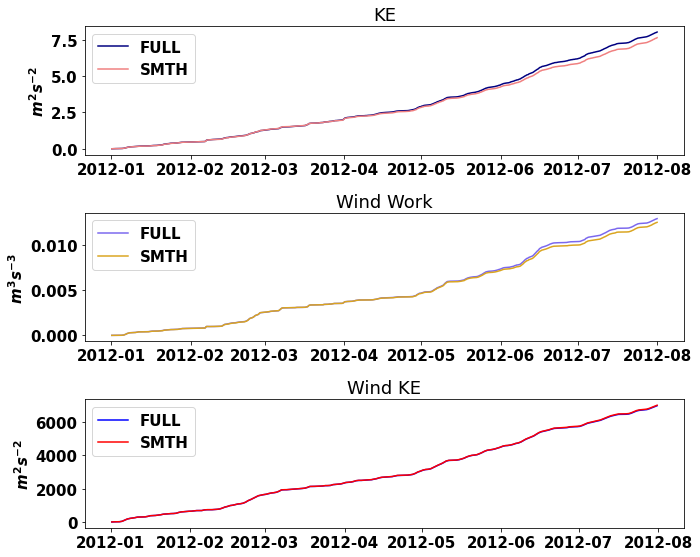

In [188]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(ufnew.time_counter,np.cumsum(Kef1),label='FULL',color='navy')
plt.plot(utnew.time_counter,np.cumsum(Ket1),label='SMTH',color='lightcoral')
plt.title('KE')
plt.ylabel(r'$m^2 s^{-2}$')
plt.legend()
# plt.xlim(ufnew.time_counter[400].data,ufnew.time_counter[-1].data)
# plt.ylim(5,30)

plt.subplot(3,1,2)

plt.plot(ufnew.time_counter,np.cumsum(Fkf1),label='FULL',color='mediumslateblue')
plt.plot(utnew.time_counter,np.cumsum(Fkt1),label='SMTH',color='goldenrod')
plt.legend()
plt.title('Wind Work')
plt.ylabel(r'$m^3 s^{-3}$')
# plt.xlim(ufnew.time_counter[400].data,ufnew.time_counter[-1].data)





plt.subplot(3,1,3)

plt.plot(vf.time_counter,np.cumsum(WKef1),label='FULL',color='blue')
plt.plot(vt.time_counter,np.cumsum(WKet1),label='SMTH',color='red')
plt.title('Wind KE')
plt.ylabel(r'$m^2 s^{-2}$')
plt.legend()
plt.tight_layout()
# plt.xlim(vf.time_counter[100].data,vf.time_counter[-1].data)
# plt.ylim(1000,8100)